In [1]:
from river.datasets import synth
from river import tree, stream, metrics, drift,forest
from itertools import chain
from itertools import cycle
import itertools
import random
import helper_lib
import importlib
from helper_lib import group_close_numbers, transform_drift_detections_into_intervals
from helper_lib import take_tests_for_streams_on_tree, prefix_sum, take_tests_for_streams_on_given_model
from helper_lib import take_tests_for_streams_on_given_model_experimental, visualize_interval_differences, visualize_results
from helper_lib import take_tests_for_streams_on_given_model_detectors_dynamic_pool
from helper_lib import take_tests_for_streams_on_given_model_fast_detectors_dynamic_pool
from helper_lib import calculate_drift_intervals
from complex_generators import generate_cyclical_drift_stream, generate_random_chain_stream
from model_factory import ARFModelFactory,TreeModelFactory

In [2]:
generator_pool_size=3
number_of_generators=6
number_of_features=5
samples_per_generator=[20000 for _ in range(number_of_generators)]
width=[2000,4000,6000,4000,2000]
seed=1
chained_generator, drift_widths = generate_cyclical_drift_stream(
    generator_pool_size=generator_pool_size,
    number_of_generators=number_of_generators,
    number_of_features=number_of_features,
    samples_per_generator=samples_per_generator,
    width=width,
    seed=1
)

1
20000
Synthetic data generator

    Name  Hyperplane           
    Task  Binary classification
 Samples  ∞                    
Features  5                    
 Outputs  1                    
 Classes  2                    
  Sparse  False                

Configuration
-------------
            seed  149213
      n_features  5     
n_drift_features  0     
      mag_change  0.0   
noise_percentage  0     
           sigma  0     
2
40000
Synthetic data generator

    Name  Hyperplane           
    Task  Binary classification
 Samples  ∞                    
Features  5                    
 Outputs  1                    
 Classes  2                    
  Sparse  False                

Configuration
-------------
            seed  16543
      n_features  5    
n_drift_features  0    
      mag_change  0.0  
noise_percentage  0    
           sigma  0    
3
60000
Synthetic data generator

    Name  Hyperplane           
    Task  Binary classification
 Samples  ∞                    
Fe

In [3]:
def ADWIN_detector_factory():
    return drift.ADWIN()
def KSWIN_detector_factory():
    return drift.KSWIN()
def DDM_detector_factory():
    return drift.binary.DDM()
def HDDM_A_detector_factory():
    return drift.binary.HDDM_A()
def HDDM_W_detector_factory():
    return drift.binary.HDDM_W()


all_samples_number = sum(samples_per_generator)
metric = metrics.ClassificationReport()
number_of_detectors = 50

In [4]:
detected_change_points, accuracys_windowed,binary_accuracy = take_tests_for_streams_on_given_model_fast_detectors_dynamic_pool(
        chained_generator,
        all_samples_number,
        metric,
        detector_factories = {
            "ADWIN": ADWIN_detector_factory,
            #KSWIN": KSWIN_detector_factory,
            "DDM": DDM_detector_factory,
            "HDDM_A": HDDM_A_detector_factory,
            "HDDM_W": HDDM_W_detector_factory,
        },
        model_factory=ARFModelFactory(),
        number_of_detectors=number_of_detectors,
        detector_offset=80
    )

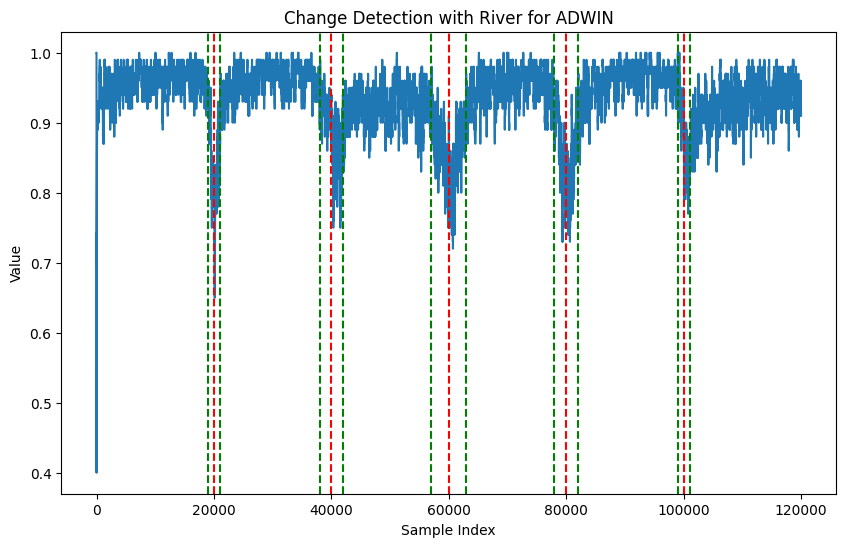

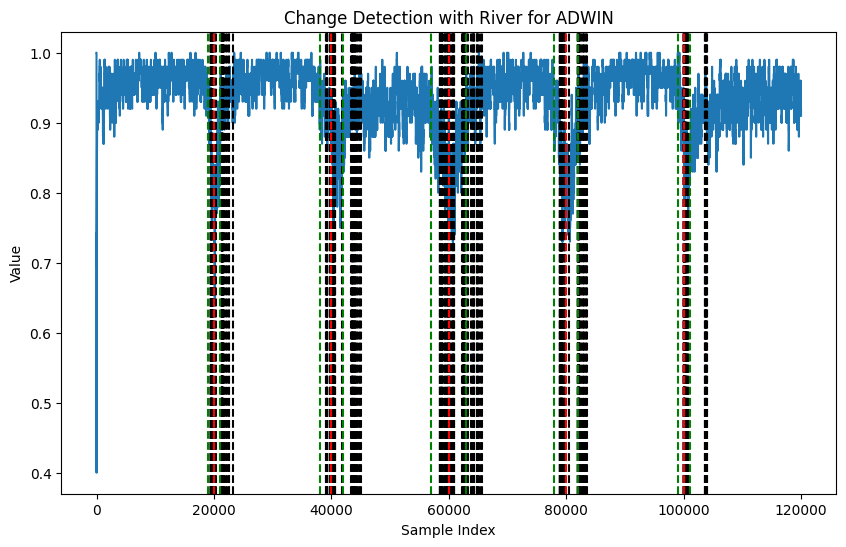

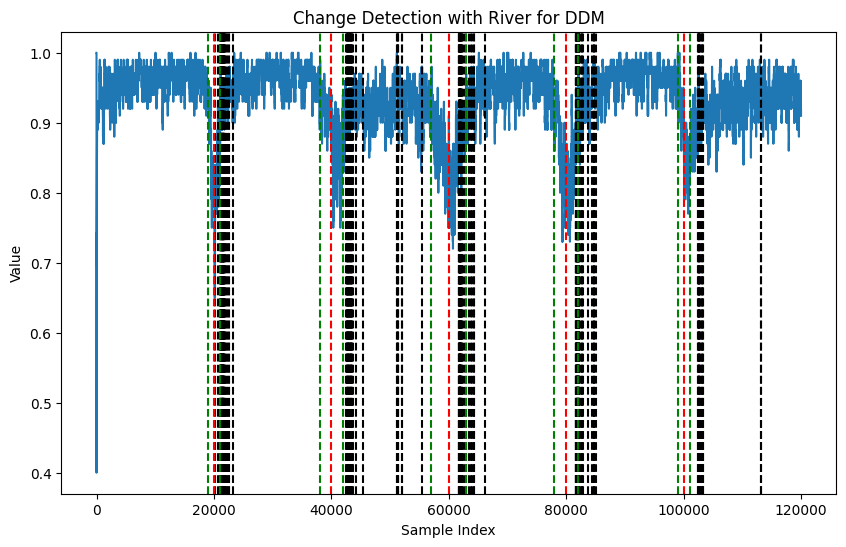

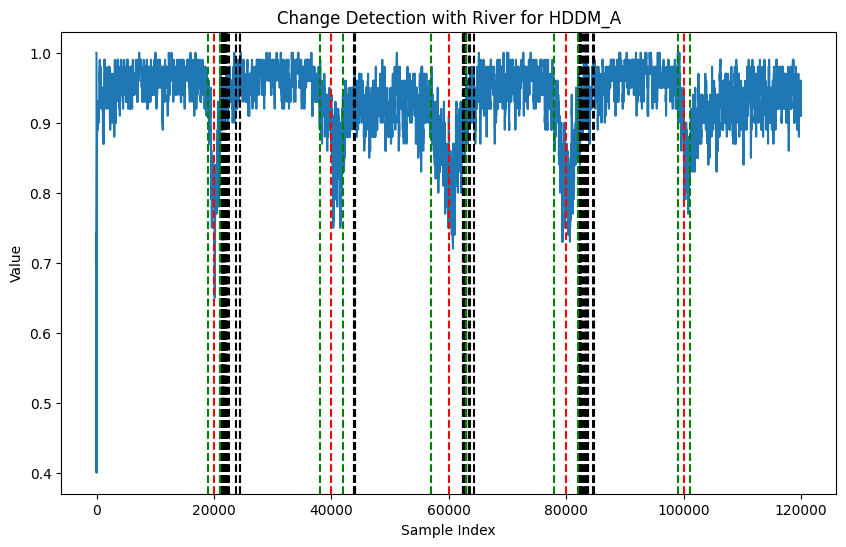

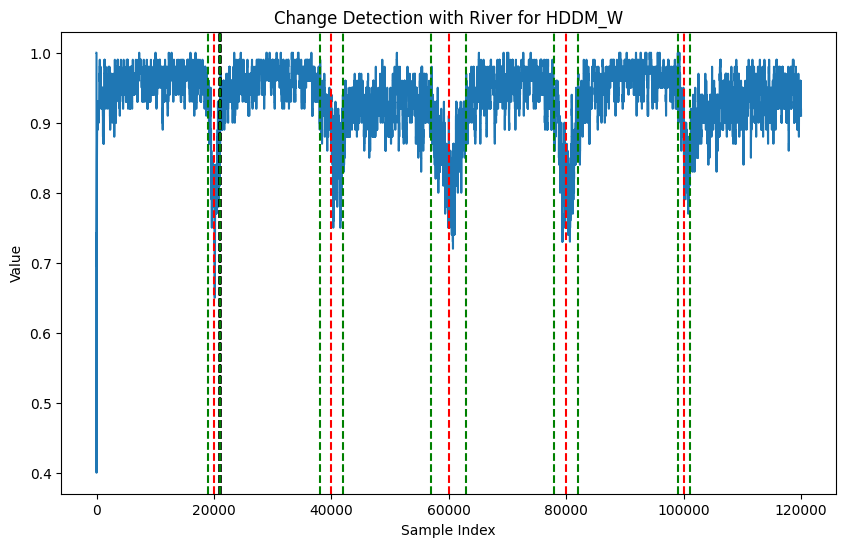

In [5]:
true_drift_points = prefix_sum(samples_per_generator)
visualize_results({"ADWIN":[]}, true_drift_points,drift_widths, accuracys_windowed)
visualize_results(detected_change_points, true_drift_points,drift_widths, accuracys_windowed)

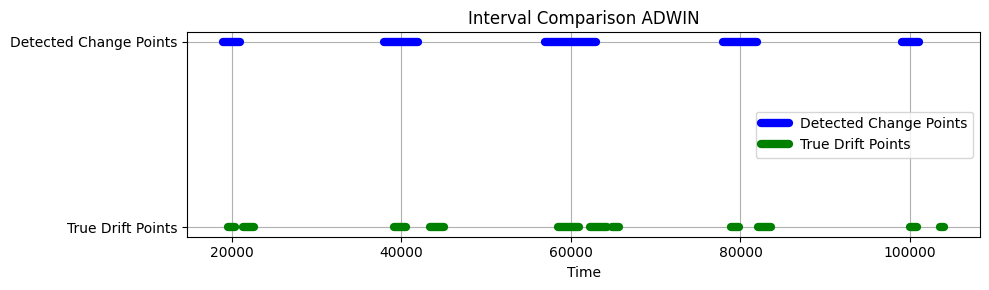

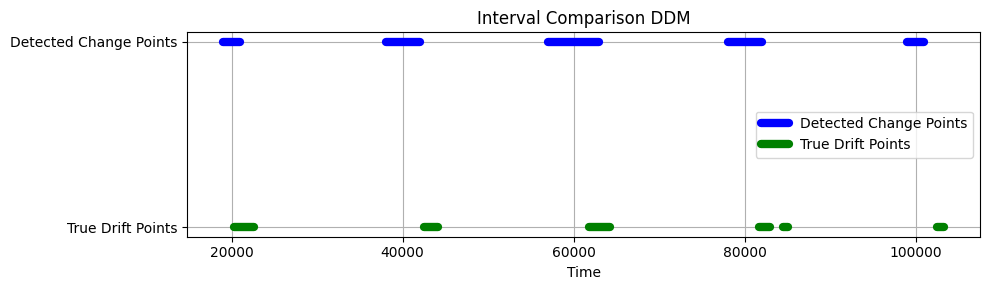

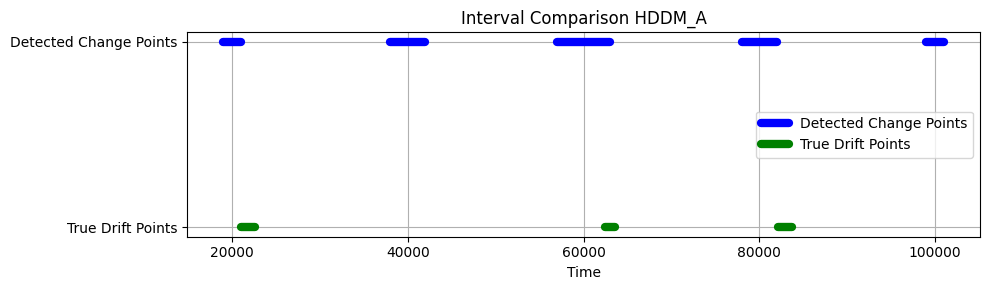

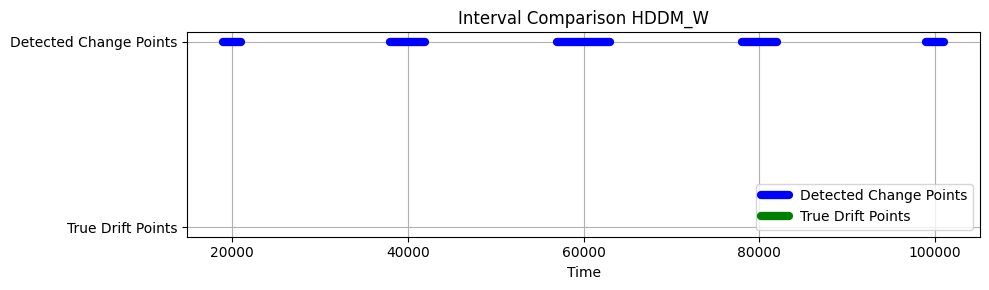

In [6]:
importlib.reload(helper_lib)
intervals_a = calculate_drift_intervals(true_drift_points,drift_widths)
for name,detected_point in detected_change_points.items():
    intervals_b = transform_drift_detections_into_intervals(detected_change_points[name],500,4)
    helper_lib.visualize_interval_differences(intervals_a, intervals_b, labels=('Detected Change Points', 'True Drift Points'),name=name)

In [17]:
import dice
import importlib
importlib.reload(dice)
dice_coefficients= {}

for DD_name,detected_point in detected_change_points.items():
    intervals_b = transform_drift_detections_into_intervals(detected_change_points[DD_name],500,5)
    dice_coefficients[DD_name]=dice.dice_coefficient(intervals_a, intervals_b)

sorted_dict = dict(sorted(dice_coefficients.items(), key=lambda item: item[1],reverse=True))
for name,value in sorted_dict.items():
    print(f"{name}: {value}")

ADWIN: 0.4426850471932439
DDM: 0.176702307259426
HDDM_A: 0.053693079956973824
HDDM_W: 0.0
